In [172]:
import sys

# sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
# import cv2

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
# import munkres
# reload(munkres)
from munkres import munkres

# https://github.com/jfrelinger/cython-munkres-wrapper,
# 10 times faster than the python implementation http://software.clapper.org/munkres/

# from munkres import Munkres # http://software.clapper.org/munkres/

sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *
import os
import time

import random

os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/csd395/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from sklearn.preprocessing import normalize

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

In [173]:
# def sort_counterclockwise(pts, return_order=False):
#     '''
#     sort points from -pi to pi with respect to center
#     '''
#     center = np.mean(pts, axis=0)
#     vecs = pts - center
#     angles = np.arctan2(vecs[:,1], vecs[:,0])
#     order = np.argsort(angles)
#     if return_order:
#         return pts[order], order
#     else:
#         return pts[order]

def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    Reference: http://nghiaho.com/?page_id=671
    '''

    n = X.shape[0]
    assert X.shape[0] == Y.shape[0], 'two point sets have different size'
    assert n >= 2, 'rgiid transform estimate needs at least two points'
    
    X = X.T
    Y = Y.T
    
    Xcentroid = X.mean(axis=1)
    Ycentroid = Y.mean(axis=1)
    
    Xcentered = X - Xcentroid[:, np.newaxis]
    Ycentered = Y - Ycentroid[:, np.newaxis]
    
    U, S, V = np.linalg.svd(np.dot(Xcentered, Ycentered.T))
    R = np.dot(V, U.T)
    d = np.linalg.det(R)
    if d < 0:
        R[1] *= -1
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid - np.dot(R, Xcentroid)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    return pts1_trans[:,:2]

In [174]:
def plot_two_pointsets(pts1, pts2, center1=True, center2=True, text=True, 
                       matchings=None,
                       show_sc1=None, show_sc2=None, r_array=None, n_angles=None):
    '''
    show_sc1 is the point index on which to draw shape context polar histogram boundaries
    '''
    
    pts1 = pts1*np.array([1,-1])
    pts2 = pts2*np.array([1,-1])

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
#     ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=40)
#     ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=40)
    ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=5)
    ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=5)

    if center1:
        center1 = pts1.mean(axis=0)
        ax.scatter(center1[0], center1[1], c='b')

    if center2:
        center2 = pts2.mean(axis=0)
        ax.scatter(center2[0], center2[1], c='b')

    if text:
        for i, (y,x) in enumerate(pts1):
            ax.text(y, x, str(i), color='r')

        for i, (y,x) in enumerate(pts2):
            ax.text(y, x, str(i), color='g')
    
    if matchings is not None:
        for i,j in matchings:
            ln = plt.Line2D(np.r_[pts1[i,0], pts2[j,0]], np.r_[pts1[i,1], pts2[j,1]], c='k')
            fig.gca().add_artist(ln)
    
    if show_sc1 is not None:
        assert r_array is not None and n_angles is not None
        dists_max1 = pdist(pts1).max() 
        scales1 = dists_max1 * r_array
        
        for s in scales1:
            circle = plt.Circle(pts1[show_sc1], s, color='k', fill=False)
            fig.gca().add_artist(circle)

        angs = np.linspace(np.pi, -np.pi, n_angles+1)[:-1]
        na = len(angs)
        for ai, a in enumerate(angs):
            ln = plt.Line2D(np.r_[pts1[show_sc1,0], pts1[show_sc1,0]+scales1[-1]*np.cos(a)], 
                            np.r_[pts1[show_sc1,1], pts1[show_sc1,1]+scales1[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)
            fig.gca().text(.5*(pts1[show_sc1,0]+scales1[0]*np.cos(a))+.5*(pts1[show_sc1,0]+scales1[0]*np.cos(angs[(ai+1)%na])), 
                           .5*(pts1[show_sc1,1]+scales1[0]*np.sin(a))+.5*(pts1[show_sc1,1]+scales1[0]*np.sin(angs[(ai+1)%na])), 
                           str(ai),
                           horizontalalignment='center',
                           verticalalignment='center')
            
    if show_sc2 is not None:
        assert r_array is not None and n_angles is not None
        dists_max2 = pdist(pts2).max()
        scales2 = dists_max2 * r_array

        for s in scales2:
            circle = plt.Circle(pts2[show_sc2], s, color='k', fill=False)
            fig.gca().add_artist(circle)
            
        angs = np.linspace(np.pi, -np.pi, n_angles+1)[:-1]
        na = len(angs)
        for ai, a in enumerate(angs):
            ln = plt.Line2D(np.r_[pts2[show_sc2,0], pts2[show_sc2,0]+scales2[-1]*np.cos(a)], 
                            np.r_[pts2[show_sc2,1], pts2[show_sc2,1]+scales2[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)
            fig.gca().text(.5*(pts2[show_sc2,0]+scales2[0]*np.cos(a))+.5*(pts2[show_sc2,0]+scales2[0]*np.cos(angs[(ai+1)%na])), 
               .5*(pts2[show_sc2,1]+scales2[0]*np.sin(a))+.5*(pts2[show_sc2,1]+scales2[0]*np.sin(angs[(ai+1)%na])), 
               str(ai),
               horizontalalignment='center',
               verticalalignment='center')


            
#     ax.legend()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [4]:
def stable(rankings, A, B):
    partners = dict((a, (rankings[(a, 1)], 1)) for a in A)
    is_stable = False # whether the current pairing (given by `partners`) is stable
    while is_stable == False:
        is_stable = True
        for b in B:
            is_paired = False # whether b has a pair which b ranks <= to n
            for n in range(1, len(B) + 1):
                a = rankings[(b, n)]
                a_partner, a_n = partners[a]
                if a_partner == b:
                    if is_paired:
                        is_stable = False
                        partners[a] = (rankings[(a, a_n + 1)], a_n + 1)
                    else:
                        is_paired = True
    return sorted((a, b) for (a, (b, n)) in partners.items())


def stable_marriage_matchings(D_boundaries):

    A = ['A'+str(i) for i in range(n_boundaries1)]
    B = ['B'+str(i) for i in range(n_boundaries2)]

    ao = np.zeros(D_boundaries)
    for q in range(n_boundaries1):
        ao[q, np.argsort(D_boundaries[q,:])] = np.arange(n_boundaries2)

    bo = np.zeros_like(D_boundaries.T)
    for q in range(n_boundaries2):
        bo[q, np.argsort(D_boundaries[:,q])] = np.arange(n_boundaries1)

    rankings1 = zip(A, ao+1)
    rankings2 = zip(B, bo+1)
    rank = dict(rankings1+rankings2)

    Arankings = dict(((a, rank[a][b_]), B[b_]) for (a, b_) in product(A, range(n_boundaries2)))
    Brankings = dict(((b, rank[b][a_]), A[a_]) for (b, a_) in product(B, range(n_boundaries1)))
    rankings = Arankings
    rankings.update(Brankings)

    m = stable(rankings, A, B)
    m = [(int(i[1:]), int(j[1:])) for i, j in m]
    m = sorted([(D_boundaries[i,j], i,j) for i,j in m if D_boundaries[i,j]<np.inf])

#     for s, i,j in m:
#         print s, i, j
    
    return m

def greedy_matching(D_boundaries, verified_matchings=[], excluded_matchings=[]):
    
    thresh_percentage = .2
    th = np.sort(D_boundaries[D_boundaries < np.inf].flat)[int(len(D_boundaries[D_boundaries < np.inf].flat)*thresh_percentage)]
    print 'thresh', th
    
    matchings = verified_matchings[:]
    rs, cs = np.unravel_index(np.argsort(D_boundaries.flat), D_boundaries.shape)
    for r, c in zip(rs, cs):
        if (r,c) in excluded_matchings:
            continue
        if D_boundaries[r,c] > th:
            break
        if r not in [i for i,j in matchings] and c not in [j for i,j in matchings]:
            matchings.append((r,c))
            
    return matchings

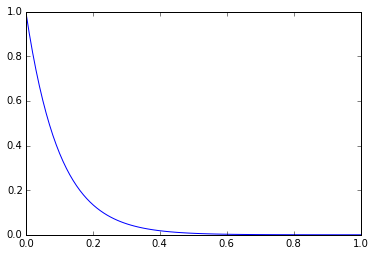

In [6]:
plt.plot(np.linspace(0,1,100), np.exp(-10*np.linspace(0,1,100)))

In [7]:
import networkx as nx

In [71]:
from scipy.misc import comb

def ransac_compute_rigid_transform(Dm, pts1, pts2, 
                                   confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                   matching_iter=10, n_neighbors=10):

#     q = time.time()

    N1 = len(pts1)
    N2 = len(pts2)
    
    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * np.size(Dm))]
#     print 'high_confidence_thresh', high_confidence_thresh
    rs, cs = np.where(Dm < high_confidence_thresh)
    high_confidence_pairs = np.c_[rs,cs]
    
    if len(high_confidence_pairs) == 0:
        return None, [], None, np.inf, 0
    
#     if OUTPUT:
#         print 'high_confidence_pairs'
#         print high_confidence_pairs
       
    p1s = np.sort(list(set(rs)))
    p2s = np.sort(list(set(cs)))
    n1 = len(p1s)
    n2 = len(p2s)
    
    if n1 < sample_size or n2 < sample_size:
        return None, [], None, np.inf, 0
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    angles = []
    coverages = []
    
    sample_counter = 0
    n_possible_samples = int(comb(len(high_confidence_pairs), sample_size, exact=False))

#     n_possible_samples = len(possible_samples)
    for ri in range(min(ransac_iters, n_possible_samples)):
        
        samples = []
        
        for tt in range(1000):
#             s = possible_samples[sample_counter]
            s = random.sample(high_confidence_pairs, sample_size)
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break
        
        if len(samples)==0:
            return None, [], None, np.inf, 0

#         samples = np.array(possible_samples[ri])

        if OUTPUT:
            print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/4:
            if OUTPUT:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching

            t1 = time.time()
            if OUTPUT:
                print 'iter %d' % mi
        
#             b = time.time()
    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dnn1 = Dh.argsort(axis=1)
            Dnn2 = Dh.argsort(axis=0).T
#             print 'cdist', time.time() - b
        
#             b = time.time()
            D2 = Dh.copy()
            D2[np.arange(N1)[:,None], Dnn1[:,n_neighbors:]] = 999
            D2[Dnn2[:,n_neighbors:], np.arange(N2)[:,None]] = 999
            D2[Dm==np.inf] = 999
#             D_hc_pairs = D2[p1s[:,np.newaxis], p2s]
#             print 'D_hc_pairs', time.time() - b

            if matches is not None:
                matches_prev = matches
            
            b = time.time()
#             matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
    
#             Ah = Dh.max() - Dh
#             B = nx.Graph()
# #             B.add_nodes_from(range(N1), bipartite=0)
# #             B.add_nodes_from(range(N1,N1+N2), bipartite=1)
#             B.add_nodes_from(range(N1))
#             B.add_nodes_from(range(N1, N1+N2))
#             edges = [(i, N1+n, {'weight':Ah[i,n]}) for i in range(N1) for n in Dnn1[i,:3]] +\
#                     [(n, N1+j, {'weight':Ah[n,j]}) for j in range(N2) for n in Dnn2[j,:3]]
#             B.add_edges_from(edges)
    
#             matches = nx.max_weight_matching(B).items()
#             matches = map(sorted, matches)
#             matches = np.array([(i, j-N1) for i,j in matches])
    
            matches = zip(*np.nonzero(munkres(D2)))
            matches = np.array([(i,j) for i,j in matches if D2[i,j] != 999])
        
            if OUTPUT:
                print 'munkres', time.time() - b
                   
            if len(matches) < 3:
                r = 0
                s = np.inf
                if OUTPUT:
                    print 'match too few, break'
                    print 'iter', time.time() - t1
                break
            else:
#                 xs1 = pts1_trans[matches[:,0], 0]
#                 x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
#                 ys1 = pts1_trans[matches[:,0], 1]
#                 y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
#                 xs2 = pts2[matches[:,1], 0]
#                 x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
#                 ys2 = pts2[matches[:,1], 1]
#                 y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
#                 coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
#                 s = Dh[matches[:,0], matches[:,1]].mean() / coverage**2
                
                r = float(len(set([i for i,j in matches])))/N1 * float(len(set([j for i,j in matches])))/N2
                m = Dh[matches[:,0], matches[:,1]].mean() / 100.
                s = r * m + (1-r) * 5.
    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/4:
                if OUTPUT:
                    print 'angle too wide, break'
                    print 'iter', time.time() - t1
                break

            pts1_trans = rigid_transform_to(pts1, T)
            
            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                if OUTPUT:
                    print 'matching no change, break'
                    print 'iter', time.time() - t1

                break
                
#             print 'coverage and remaining', mi, time.time() - t2
            if OUTPUT:
                print 'iter', time.time() - t1
                
                            
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
        angles.append(angle)
#         print 'score', s
#         print len(matches), 'matches'
        
        coverages.append(r)
    
#         print matches
#         print s
#         plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
#                    center1=False, center2=False,
#                    text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]
        best_angle = angles[best_i]
#         print len(best_matches)
#         print np.rad2deg(best_angle)
        best_coverage = coverages[best_i]
        
#         print 'best_coverage', best_coverage

    
        return best_T, best_matches, best_sample, best_score, best_coverage
    else:
        return None, [], None, np.inf, 0

In [105]:
def boundary_distance(b1, b2, ev1=None, ev2=None, sc1=None, sc2=None, loc_thresh=1500):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    edges1, interior_texture1, exterior_textures1, points1, center1 = b1
    edges2, interior_texture2, exterior_textures2, points2, center2 = b2
    
    edges1 = list(edges1)
    edges2 = list(edges2)
    
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)
    
#     print 'd_loc', d_loc

    if d_loc > loc_thresh:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)
#     D_ext = hausdorff_histograms(exterior_textures1, exterior_textures2, metric=chi2)

    # compute shape difference, exterior texture difference
#     D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2)

    n_radial_bins = 5
    n_polar_bins = 12

#     if sc1 is None:
    sc1, po1 = compute_shape_context_descriptors(points1, n_radial_bins, n_polar_bins, dist_limit=1)
    
#     if sc2 is None:
    sc2, po2 = compute_shape_context_descriptors(points2, n_radial_bins, n_polar_bins, dist_limit=1)
    
    descriptor_dists = cdist(sc1, sc2, metric='euclidean')
    
    a_diff_thresh = np.pi / 4
    b_diff_thresh = a_diff_thresh / (2 * np.pi / n_polar_bins)
    sc_orientation_similarity = np.array([[(np.abs(a1 - a2)) < b_diff_thresh for a2 in po2] for a1 in po1])
    descriptor_dists[~sc_orientation_similarity] = np.inf
    
    if ev1 is not None and ev2 is not None:
        edge_orientation_similarity = np.dot(ev1, ev2.T) > np.cos(np.pi/4)
        descriptor_dists[~edge_orientation_similarity] = np.inf

#     b = time.time()
    T, matches, best_sample, D_shape, coverage = ransac_compute_rigid_transform(descriptor_dists, points1, points2, 
                                                                      ransac_iters=50, confidence_thresh=0.03, 
                                                                      sample_size=3, matching_iter=10,
                                                                      n_neighbors=3)
#     print 'ransac_compute_rigid_transform', time.time() - b
    
#     print coverage
    
    if len(matches) == 0:
        D_shape = np.inf

#         D_ext = np.mean([chi2(exterior_textures1[i], exterior_textures2[j]) for i, j in matches])
    
    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if OUTPUT:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
        
        D_ext = coverage * D_ext + (1-coverage)*5.
    
    D_shape = .2 * D_shape
    D_ext = .2 * D_ext
    
    # weighted average of four terms
    d = D_int + D_ext + D_shape + 0 * D_loc
    
    return d, D_int, D_ext, D_shape, D_loc


In [175]:
sec1 = 8
sec2 = 9

dm1 = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec1)
dm2 = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec2)

boundaries1 = dm1.load_pipeline_result('boundaryModels', 'pkl')
boundaries2 = dm2.load_pipeline_result('boundaryModels', 'pkl')

n_boundaries1 = len(boundaries1)
n_boundaries2 = len(boundaries2)
print n_boundaries1, n_boundaries2

# sc1 = dm1.load_pipeline_result('shapeContext', 'pkl')
# sc2 = dm2.load_pipeline_result('shapeContext', 'pkl')

# lm_types1 = dm1.load_pipeline_result('nonoverlapLmTypes', 'npy')
# lm_types2 = dm2.load_pipeline_result('nonoverlapLmTypes', 'npy')

40 40


In [182]:
# from skimage.segmentation import random_walker
# m = np.zeros_like(dm2.image, np.bool)
# m[5,5] = 1
# q = random_walker(dm2.image, m)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/function_base.py:1114: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
  return a[slice1]-a[slice2]


In [148]:
boundary_ind1 = 23
boundary_ind2 = 17


pts1 = boundaries1[boundary_ind1][3].copy()
pts2 = boundaries2[boundary_ind2][3].copy()

edges1 = boundaries1[boundary_ind1][0]
edges2 = boundaries2[boundary_ind2][0]
edges1 = list(edges1)
edges2 = list(edges2)

ev1 = dm1.load_pipeline_result('edgeVectors', 'pkl')
ev2 = dm2.load_pipeline_result('edgeVectors', 'pkl')

bev1 = np.array([ev1[e] for e in edges1])
bev2 = np.array([ev2[e] for e in edges2])



In [149]:
OUTPUT= False

b = time.time()
print boundary_distance(boundaries1[boundary_ind1], boundaries2[boundary_ind2], ev1=bev1, ev2=bev2)
print time.time() - b

(2.6449486343827964, 1.2233291541693336, 0.72791775136656867, 0.69370172884689418, 0.0)
0.195511102676


In [147]:
OUTPUT= False

b = time.time()
print boundary_distance(boundaries1[boundary_ind1], boundaries2[boundary_ind2], ev1=bev1, ev2=bev2)
print time.time() - b

(1.8481237599068696, 0.22662566854319854, 0.8306457058861284, 0.79085238547754277, 838.77056618838787)
0.24010515213


18
coverage 0.190588235294
score 4.14034601349


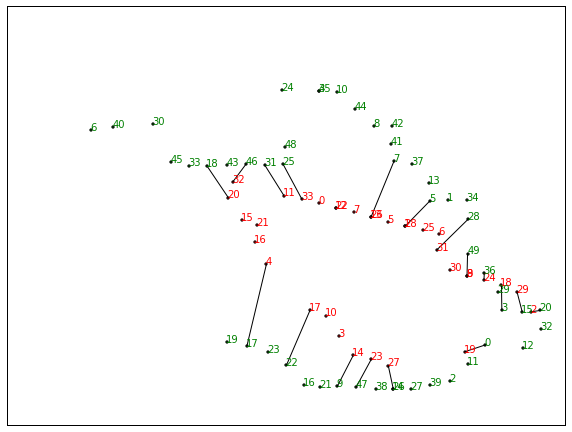

In [145]:
OUTPUT= False

n_radial_bins = 5
n_polar_bins = 12
dist_limit = 1.

descriptor1, po1 = compute_shape_context_descriptors(pts1, n_radial_bins, dist_limit=dist_limit)
descriptor2, po2 = compute_shape_context_descriptors(pts2, n_radial_bins, dist_limit=dist_limit)
descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')

a_diff_thresh = np.pi / 4
b_diff_thresh = a_diff_thresh / (2 * np.pi / n_polar_bins)
orientation_compatibility = np.array([[(np.abs(a1 - a2)) < b_diff_thresh for a2 in po2] for a1 in po1])
descriptor_dists[~orientation_compatibility] = np.inf

edge_orientation_similarity = np.dot(bev1, bev2.T) > np.cos(np.pi/4)
descriptor_dists[~edge_orientation_similarity] = np.inf

# confidence_thresh = .03
# high_confidence_thresh = np.sort(descriptor_dists.flat)[int(confidence_thresh * np.size(descriptor_dists))]
# print high_confidence_thresh
# rs, cs = np.where(descriptor_dists < high_confidence_thresh)
# high_confidence_pairs = np.c_[rs,cs]

r_array, theta_array = compute_r_theta_bins(n_radial_bins=n_radial_bins, n_polar_bins=n_polar_bins, dist_limit=dist_limit)

T, matching, sample, score, coverage = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                        ransac_iters=50, confidence_thresh=0.03, 
                                                        sample_size=3, matching_iter=10, n_neighbors=3)


# print 'matching', matching
# print 'sample', sample
print len(matching)
print 'coverage',coverage
print 'score', score

pts1_trans = rigid_transform_to(pts1, T)

plot_two_pointsets(pts1_trans, pts2, center1=False, center2=False,
#                   show_sc1=70, r_array=r_array, n_angles=12, 
                   text=True, matchings=matching)

In [ ]:
# Ss = []
# for i in range(100):
#     print i

#     T, matching, sample, score, coverage = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
#                                                             ransac_iters=50, confidence_thresh=0.03, 
#                                                             sample_size=3, matching_iter=10, n_neighbors=3)
#     Ss.append(score)


# print np.std(Ss)
# m = np.mean(Ss)
# plt.hist(Ss, bins=np.arange(m-10,m+10,.1));

In [12]:
def centering(ps):
    return ps - ps.mean(axis=0)

def hausdorff(ps1, ps2, center=False):
    if center:
        ps1 = centering(ps1)
        ps2 = centering(ps2)
    D = cdist(ps1, ps2)
    return max(np.max(D.min(axis=0)), np.max(D.min(axis=1)))

def hausdorff_histograms(h1s, h2s, metric):
    Ds = cdist(h1s, h2s, metric)
    return max(np.nanmax(np.nanmin(Ds, axis=1)), np.nanmax(np.nanmin(Ds, axis=0)))


def regulate_angles(a):
    angles = a%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi
    return angles

def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

#     closest_neighbor = dists.argsort(axis=1)[:,1]
#     tangent_vectors = points[closest_neighbor] - points
#     tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

#     angles = angles - tangent_angles[:, np.newaxis]

    angles = regulate_angles(angles)
    
#     tangent_angles = regulate_angles(tangent_angles)
    
    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1
            
    polar_counts = descriptors_mat.sum(axis=1)
    polar_proportions = polar_counts.astype(np.float) / polar_counts.sum(axis=-1)[:, None]
    peak_orientations = np.argmax(polar_proportions, axis=-1)
    for pt_ind, po in enumerate(peak_orientations):
        descriptors_mat[pt_ind] = np.roll(descriptors_mat[pt_ind], shift=-po, axis=-1)

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1)

    if density:
        descriptors = normalize(descriptors.astype(np.float), axis=1)
    
    return descriptors, peak_orientations
#     return descriptors, None

In [ ]:
# OUTPUT = False
# Ds = []
# for i, j in product(range(n_boundaries1), range(n_boundaries2)):
#     b = time.time()
#     a = boundary_distance(boundaries1[i], boundaries2[j])
#     Ds.append(a)
#     sys.stderr.write('%d,%d,%f\n'%(i,j,time.time()-b))

In [129]:
OUTPUT=False

# sc1 = dm1.load_pipeline_result('shapeContext', 'pkl')
# sc2 = dm2.load_pipeline_result('shapeContext', 'pkl')

ev1 = dm1.load_pipeline_result('edgeVectors', 'pkl')
ev2 = dm2.load_pipeline_result('edgeVectors', 'pkl')

bev1 = [np.array([ev1[e] for e in boundaries1[i][0]]) for i in range(n_boundaries1)]
bev2 = [np.array([ev2[e] for e in boundaries2[j][0]]) for j in range(n_boundaries2)]

Ds = Parallel(n_jobs=16)(delayed(boundary_distance)(boundaries1[i], boundaries2[j], ev1=bev1[i], ev2=bev2[j]) 
                         for i, j in product(range(n_boundaries1), range(n_boundaries2)))
D_boundaries, D_int, D_ext, D_shape, D_loc = zip(*Ds)

D_boundaries = np.reshape(D_boundaries, (n_boundaries1, n_boundaries2))
D1 = np.reshape(D_int, (n_boundaries1, n_boundaries2))
D2 = np.reshape(D_ext, (n_boundaries1, n_boundaries2))
D3 = np.reshape(D_shape, (n_boundaries1, n_boundaries2))
D4 = np.reshape(D_loc, (n_boundaries1, n_boundaries2))

In [118]:
D_boundaries = dm1.load_pipeline_result('DBoundaries%dWith%d'%(sec1,sec2), 'npy')
D1 = dm1.load_pipeline_result('D1s%dWith%d'%(sec1,sec2), 'npy')
D2 = dm1.load_pipeline_result('D2s%dWith%d'%(sec1,sec2), 'npy')
D3 = dm1.load_pipeline_result('D3s%dWith%d'%(sec1,sec2), 'npy')

In [141]:
print np.mean(D1[D1!=np.inf])
print np.mean(D2[D2!=np.inf])
print np.mean(D3[D3!=np.inf])

0.760787965843
0.914734754115
0.90109891505


In [135]:
boundary_supporters1 = dm1.load_pipeline_result('goodEdgeSetsSupporters', 'pkl')
boundary_supporters2 = dm2.load_pipeline_result('goodEdgeSetsSupporters', 'pkl')

In [136]:
texton_hists1 = dm1.load_pipeline_result('texHist', 'npy')
texton_hists2 = dm2.load_pipeline_result('texHist', 'npy')

In [139]:
np.sort(D1[23])

array([ 0.22662567,  0.68471881,  0.78364987,  0.81868888,  0.82827638,
        1.04144233,  1.07076893,  1.14735977,  1.22332915,  1.24162861,
        1.33284362,  1.41564593,  1.44526915,  1.54741094,  1.70517574,
        1.89380987,  1.92445827,  1.93205049,  1.9335316 ,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf])

In [154]:
boundary_ind1 = 10
print D_boundaries.argsort(axis=1)[boundary_ind1,:10]
print D1.argsort(axis=1)[boundary_ind1,:10]
print D2.argsort(axis=1)[boundary_ind1,:10]
print D3.argsort(axis=1)[boundary_ind1,:10]

[ 4  1 18 13 12  7  8 38 32 31]
[ 4  1 18 13 24  7 38 12 27 21]
[ 4  8 12 18 13 32  1  7 31 38]
[ 4  8 12 18 13 32  1  7 31 38]


In [155]:
boundary_ind2 = 4
print D_boundaries.argsort(axis=0)[:5, boundary_ind2]
print D1.argsort(axis=0)[:10, boundary_ind2]
print D2.argsort(axis=0)[:10, boundary_ind2]
print D3.argsort(axis=0)[:5, boundary_ind2]

[10 27 32  9 15]
[10 27 32 15  9 17 24 25 26 28]
[10  9 27 17 15 32 24 25 26 28]
[10  9 27 17 15]


In [20]:
# D_boundaries = dm1.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec2), 'npy')
# D1 = dm1.load_pipeline_result('D1s%dWith%d'%(sec1, sec2), 'npy')
# D2 = dm1.load_pipeline_result('D2s%dWith%d'%(sec1, sec2), 'npy')
# D3 = dm1.load_pipeline_result('D3s%dWith%d'%(sec1, sec2), 'npy')
# D4 = dm1.load_pipeline_result('D4s%dWith%d'%(sec1, sec2), 'npy')

In [227]:
true_matchings = []
ok_matchings = []

excluded_matchings = []
verified_matchings = []

In [510]:
def set_to_set_matching(D_boundaries):

    DD = np.inf * np.ones((n_boundaries1+n_boundaries2, n_boundaries1+n_boundaries2))
    DD[:n_boundaries1, n_boundaries1:] = D_boundaries
    DD[n_boundaries1:, :n_boundaries1] = D_boundaries.T

    a = DD[DD!=np.inf]
    thresh = np.sort(a)[int(len(a)*.04)]
    print thresh

    import networkx as nx
    G = nx.Graph(DD < thresh)
    G = nx.relabel_nodes(G, dict([(i,(sec1,i)) for i in range(n_boundaries1)]+[(n_boundaries1+j,(sec2,j)) for j in range(n_boundaries2)]))

    ms = [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True) if len(g) >= 2]
    print len(ms)
    return ms

In [167]:
def knn_matching(D_boundaries, boundaries1, boundaries2, centroid_dist_limit=500):
    
    import networkx as nx
    
    n_boundaries1, n_boundaries2 = D_boundaries.shape
    
    nn1 = D_boundaries.argsort(axis=1)
    dd1 = np.sort(D_boundaries,axis=1)
    nn1 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd1, nn1)]
    
    nn2 = D_boundaries.argsort(axis=0).T
    dd2 = np.sort(D_boundaries,axis=0).T
    nn2 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd2, nn2)]

    DD = np.zeros((n_boundaries1+n_boundaries2, n_boundaries1+n_boundaries2))
    G = nx.Graph(DD)
    G = nx.relabel_nodes(G, dict([(i,(0,i)) for i in range(n_boundaries1)]+[(n_boundaries1+j,(1,j)) for j in range(n_boundaries2)]))
    matches = []
    for i in range(n_boundaries1):
        for j in range(n_boundaries2):
#             if j in nn1[i,:k] and i in nn2[j,:k]:
            if j in nn1[i] and i in nn2[j]:
                matches.append((i,j))
                G.add_edge((0,i), (1,j))

    ms = [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True) if len(g) >= 2]
        
    groups = []
    for mi, m in enumerate(ms):
        d = defaultdict(list)
        for sec_i, bnd_i in m:
            d[sec_i].append(bnd_i)
        A = D_boundaries[d[0]][:,d[1]]
        rs, cs = np.unravel_index(np.argsort(D_boundaries[d[0]][:,d[1]].flat), (len(d[0]), len(d[1])))
    #     print rs, cs
    #     print [((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]]) for r, c in zip(rs, cs)
    #           if D_boundaries[d[sec1][r], d[sec2][c]] < np.inf]

        g = []
        for r, c in zip(rs, cs):
            if D_boundaries[d[0][r], d[1][c]] < np.inf:
    #             print ((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]])
                g.append([d[0][r], d[1][c]])

        groups.append(g)
    
#     print groups
    
    # RANSAC
    import random

    boundary1_centers = np.array([b[4][::-1] for b in boundaries1])
    boundary2_centers = np.array([b[4][::-1] for b in boundaries2])

    matches = []
    scores = []

    for ransac_iter in range(100):

        boundary_samples = [random.sample(g, 1)[0] for g in random.sample(groups, min(len(groups), 3))]
        X = []
        Y = []
        for b1, b2 in boundary_samples:
            X.append(boundary1_centers[b1])
            Y.append(boundary2_centers[b2])
        X = np.array(X)
        Y = np.array(Y)

        T, angle = rigid_transform_from_pairs(X,Y)
    #     print T, angle
        if angle > np.pi/2:
    #         print 'angle too wide'
            matches.append([])
            scores.append(0)
            continue

        boundary1_centers_trans = rigid_transform_to(boundary1_centers, T)
#         print np.linalg.norm(boundary1_centers_trans[10]-boundary2_centers[4])

        match = [(bi,bj) for g in groups for bi,bj in g 
                 if np.linalg.norm(boundary1_centers_trans[bi] - boundary2_centers[bj]) < centroid_dist_limit]

        score = len(match)

        matches.append(match)
        scores.append(score)

    best = np.argmax(scores)
    s_best = scores[best]
    m_best = matches[best]
#     print m_best

    g = nx.Graph()
    g.add_edges_from([((0, i),(1, j), {'weight': D_boundaries[D_boundaries!=np.inf].max()-D_boundaries[i,j]}) 
                      for i,j in m_best])
    m = nx.matching.max_weight_matching(g, maxcardinality=True)
    
    best_match = set(((0, dict([n1,n2])[0]), (1, dict([n1,n2])[1])) for n1,n2 in m.iteritems())
    
    print len(best_match)
    
    return best_match

In [168]:
best_match = knn_matching(D_boundaries, boundaries1, boundaries2, centroid_dist_limit=300)
print best_match

22
set([((0, 12), (1, 14)), ((0, 31), (1, 7)), ((0, 13), (1, 36)), ((0, 9), (1, 12)), ((0, 11), (1, 5)), ((0, 20), (1, 29)), ((0, 28), (1, 17)), ((0, 0), (1, 1)), ((0, 8), (1, 11)), ((0, 14), (1, 15)), ((0, 7), (1, 22)), ((0, 33), (1, 16)), ((0, 30), (1, 6)), ((0, 17), (1, 8)), ((0, 10), (1, 4)), ((0, 1), (1, 2)), ((0, 5), (1, 3)), ((0, 15), (1, 27)), ((0, 22), (1, 25)), ((0, 24), (1, 39)), ((0, 25), (1, 33)), ((0, 2), (1, 10))])


In [169]:
def visualize_multiple_landmarks_multiple_sections_vertical(d):
    '''
    e.g. tpl = {3:[2,5,12], 4:[6,4,2]}
    '''
    
    import cv2
    
    viss = []
    for sec, bnds in d.iteritems():
        dm = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=sec)
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viz = dm.visualize_edge_sets([boundaries[b][0] for b in bnds])
        cv2.putText(viz, str(sec), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 5, ((0,0,0)), 3)
        viss.append(viz)
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    left_margins = [int((wmax - w)/2) for h,w in hws]
    right_margins = [ wmax - w - lm for (h,w), lm in zip(hws, left_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, left_margins, right_margins):
        viss_padded.append(pad(vis, ((0,0),(lm,rm),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.vstack(viss_padded)
    return vis_stacked

In [170]:
d = {sec1: [m[0][1] for m in best_match], sec2: [m[1][1] for m in best_match]}
viz = visualize_multiple_landmarks_multiple_sections_vertical(d)

In [171]:
display(viz)

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

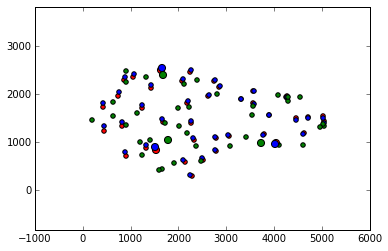

In [398]:
plt.scatter(boundary1_centers[:,0], boundary1_centers[:,1], c='r');
plt.scatter(boundary1_centers_trans[:,0], boundary1_centers_trans[:,1], c='b');
plt.scatter(boundary2_centers[:,0], boundary2_centers[:,1], c='g');
plt.axis('equal');

for b1, b2 in boundary_samples:
    plt.scatter(boundary1_centers[b1,0], boundary1_centers[b1,1], s=50, c='r');
    plt.scatter(boundary1_centers_trans[b1,0], boundary1_centers_trans[b1,1], s=50, c='b');
    plt.scatter(boundary2_centers[b2,0], boundary2_centers[b2,1], s=50, c='g');

In [191]:
for mi, m in enumerate(ms):
    d = defaultdict(list)
    for sec_i, bnd_i in m:
        d[sec_i].append(bnd_i)
    viz = visualize_multiple_landmarks_multiple_sections_vertical(d)
    imsave('/tmp/match%d.jpg'%mi, viz)

In [231]:
matchings = greedy_matching(D_boundaries, verified_matchings, excluded_matchings)

corr = 0
parcorr = 0
err = 0
# crosstype = 0

for i,j in matchings:
    print D_boundaries[i,j], i, j
    if (i,j) in true_matchings:
        corr += 1.
#         if int(lm_types1[i]) != int(lm_types2[j]):
#             crosstype += 1.
    elif (i,j) in ok_matchings:
        parcorr += 1.
#         if int(lm_types1[i]) != int(lm_types2[j]):
#             crosstype += 1.
    else:
        err += 1.
        
# n = len(matchings)
# tps = set(true_matchings) | set(ok_matchings)
# recall = (corr+parcorr)/len(tps)
# precision = (corr+parcorr)/n
# beta = 5 # means how many times recall is important than precision
# F = (1+beta**2) * (recall*precision) / (beta**2*precision + recall)
# print '\nrecall = %.2f, precision = %.2f, F = %.2f' % (recall, precision, F)

# missed = tps - set(matchings)
# print 'missed', missed, 'among them, the smallest distance is', np.min([D_boundaries[i,j] for i,j in missed])
# wrong = set(matchings) - tps
# print 'wrong', wrong
# print 'Of all correct matchings, %.1f%% is between different types' % (crosstype/n*100)

thresh 1.15145956284
0.499922230267 15 13
0.518476952595 12 9
0.531359004104 25 17
0.562409020548 8 12
0.565141546816 3 3
0.580699694362 26 31
0.60348191592 35 33
0.661771082669 30 30
0.692197128708 37 37
0.696131990026 38 6
0.700496689697 1 7
0.71110080807 11 36
0.722425662423 0 15
0.738109699912 39 19
0.748848418049 20 2
0.786082320524 33 23
0.795422050806 9 34
0.808752271406 16 11
0.809018852431 36 25
0.826431953451 24 14
0.861407901448 34 8
0.870501812023 6 10
0.87628243497 22 18
0.887783996068 27 21
0.948681115541 5 4
1.01056574704 21 1
1.13059859233 7 0


In [ ]:
# one-dimensional embedding

from networkx import from_dict_of_lists, draw_networkx, from_dict_of_dicts, dfs_edges, dfs_tree, all_pairs_dijkstra_path_length

D = pdist(boundaries1[20][3])
D = squareform(D)
D_sorted = np.sort(D, axis=1)[:,1:4]
nearest_neighbors = D.argsort(axis=1)[:,1:4]

nearest_neighbors_dict = dict([(i, dict([(j, {'weight':D_sorted[i, k]}) for k, j in enumerate(a)])) for i, a in enumerate(nearest_neighbors)])
# print nearest_neighbors_dict[0]

G = from_dict_of_dicts(nearest_neighbors_dict)
draw_networkx(G, with_labels=False, node_size=10)

# print dfs_edges(G)
draw_networkx(dfs_tree(G, 1), with_labels=False, node_size=10)

geodesic_dists_dict = all_pairs_dijkstra_path_length(G)
geodesic_dists = np.array([[d for j, d in a.iteritems()] for i, a in geodesic_dists_dict.iteritems()])
geodesic_dists = np.minimum(geodesic_dists, geodesic_dists.T)